In [1]:
# import Section
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from os import listdir
from os.path import isfile, join
import re
from matplotlib import pyplot as plt

In [2]:
def isjpg(filepath):
    return re.search(".jpg$", filepath)

In [5]:
# Function Section
def calculate_pad(brightness, saturation):
    p = 0.69*brightness + 0.22*saturation
    a = -0.31*brightness + 0.6*saturation
    d = 0.76*brightness + 0.32*saturation
    return [p,d,a]
    
def calculate_blur(img):
    return cv2.Laplacian(img, cv2.CV_64F).var()

def mean_brightness(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) #convert it to hsv
    return np.mean(hsv[:,:,2])

def mean_saturation(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) #convert it to hsv
    return np.mean(hsv[:,:,1])

def calculate_opticalFlow(img1, img2):
    f, axarr = plt.subplots(2,1)
    axarr[0].imshow(img1)
    axarr[1].imshow(img2)
    plt.show()
    prev = cv2.cvtColor(testEld[0], cv2.COLOR_BGR2GRAY)
    forward = cv2.cvtColor(testEld[1], cv2.COLOR_BGR2GRAY)
    mask = np.zeros_like(prev)
    mask[..., 1] = 255
    flow = cv2.calcOpticalFlowFarneback(prev, forward, flow=None, pyr_scale=0.5,levels =1,winsize=3,iterations=15,poly_n=3,poly_sigma=5,flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN)
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    return cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)[0]



Text(0, 0.5, 'valence')

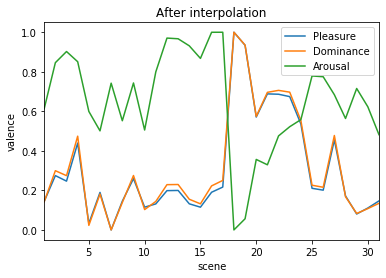

In [56]:
import glob
import re
from scipy.interpolate import interp1d

mypath = "data/scenes/toy_story_4"

files = [f for f in listdir(mypath) if isjpg(join(mypath, f))]
pad_data = []                                                                   
                                                                                
for fname in files:
    src = cv2.imread(join(mypath, fname),1)                                                    
    if(src is None):                                                            
        continue
    gx = '^[^-]*-([^-]*).*'
    p = re.compile(gx)
    scene = int(p.search(fname.replace('toy_story-','')).group(1))
    pad_data.append(calculate_pad(mean_brightness(src),mean_saturation(src)) + [scene])


    
df = pd.DataFrame(pad_data,columns=['pleasure','dominance','arousal', 'scene'] )
df = df.sort_values(by=['scene'],ascending=True)
df = df.groupby(['scene']).mean()
normalized_df=(df-df.min())/(df.max()-df.min())
normalized_df

f1 = interp1d(normalized_df.index, normalized_df['pleasure'],kind='cubic')
f2 = interp1d(normalized_df.index, normalized_df['dominance'],kind='cubic')
f3 = interp1d(normalized_df.index, normalized_df['arousal'],kind='cubic')

df2 = pd.DataFrame()
new_index = normalized_df.index
df2['Pleasure'] = f1(new_index)
df2['Dominance'] = f2(new_index)
df2['Arousal'] = f3(new_index)
df2.index = new_index

ax2 = df2.plot.line()
ax2.set_title('After interpolation')
ax2.set_xlabel("scene")
ax2.set_ylabel("valence")

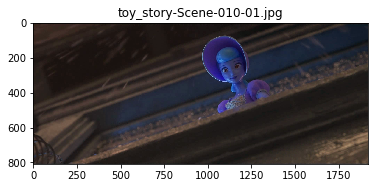

In [4]:
mypath = "data/scenes/toy_story_4"

onlyfiles = [f for f in listdir(mypath) if isjpg(join(mypath, f))]
i = 0
ans={}
testEld = []
index = []

if i < len(onlyfiles) - 1:
    test = cv2.imread(join(mypath, onlyfiles[i]))
    test_next = cv2.imread(join(mypath, onlyfiles[i+1]))

    testEld.append(test)
    testEld.append(test_next)
    plt.imshow(test)
    title = onlyfiles[i]
    plt.title(f"{title}")
    plt.show()
    i+=1

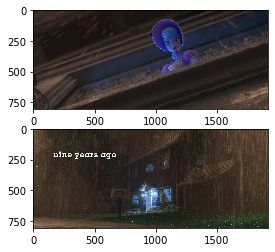

array([2.5923033e-10, 6.3751258e-08, 1.4817554e-05, ..., 2.0641835e-05,
       1.4722971e-07, 5.2004651e-10], dtype=float32)

In [8]:
calculate_opticalFlow(test, test_next)

In [2]:
calculate_pad()

In [4]:
# Model

In [5]:
# Evaluation